In [ ]:
import torch
torch.cuda.set_device(1)

In [ ]:
from local.test import *
from local.basics import *
from local.callback.all import *
from local.vision.all import *

In [ ]:
path = untar_data(URLs.CAMVID)

In [ ]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [ ]:
def ListSplitter(valid_items):
    def _inner(items):
        val_mask = tensor([o.name in valid_items for o in items])
        return [~val_mask,val_mask]
    return _inner

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, ImageBlock(cls=PILMask)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}')

In [ ]:
def rm_class(x): return torch.Tensor._make_subclass(Tensor, tensor(x))
rm_class.order=999

In [ ]:
dbunch = camvid.databunch(path/"images", bs=8, #item_tfms=Resize(sz), 
                          batch_tfms=[*aug_transforms(size=(360,480)), Normalize(*imagenet_stats)])

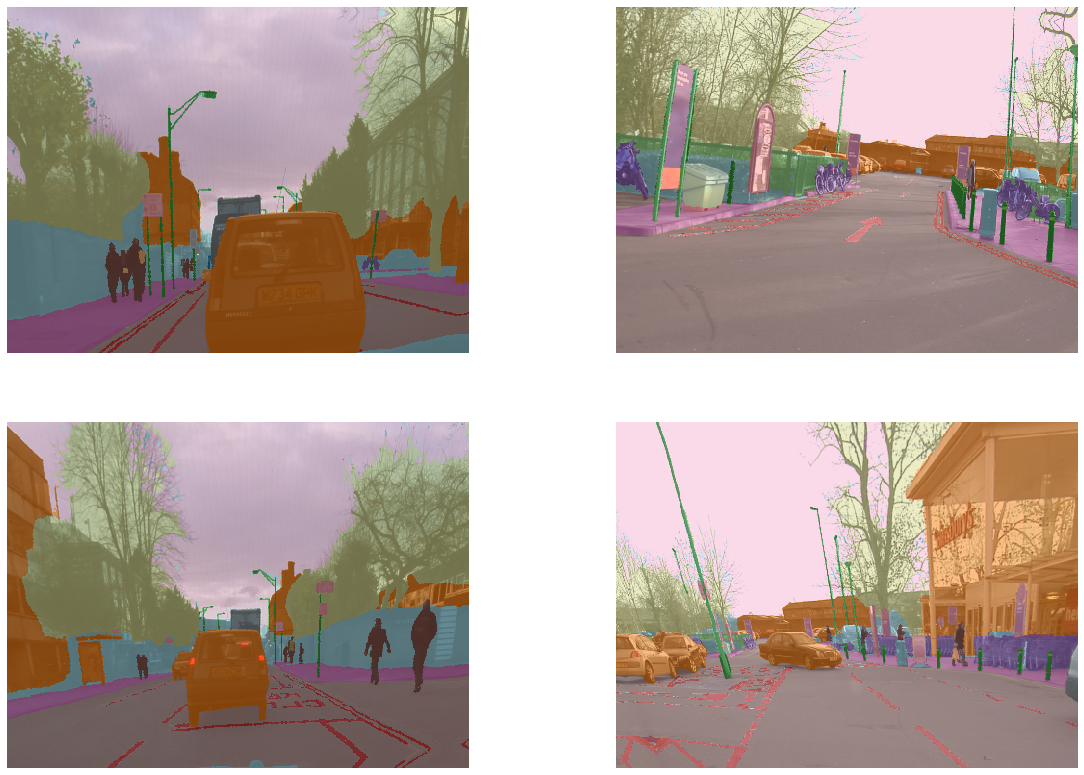

In [ ]:
dbunch.show_batch(max_n=4, vmin=1, vmax=30, figsize=(20, 14))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
dbunch.vocab = codes

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)#, eps=1e-8)

learn = unet_learner(dbunch, resnet34, loss_func=CrossEntropyLossFlat(axis=1), opt_func=opt_func, path=path, metrics=acc_camvid,
                     config = unet_config(norm_type=None), wd_bn_bias=True)

In [ ]:
get_c(dbunch)

32

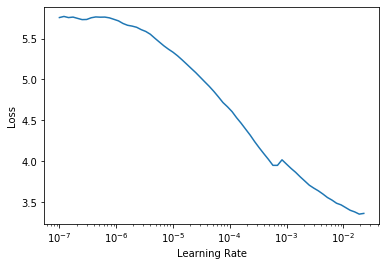

In [ ]:
learn.lr_find()

In [ ]:
lr= 3e-3
learn.freeze()

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.626712,1.042060,0.712205,00:40
1,0.853121,0.743167,0.824238,00:40
2,0.712321,0.695576,0.818584,00:40
3,0.648336,0.565680,0.845116,00:40
4,0.656058,0.518507,0.864131,00:40
5,0.608365,0.520637,0.857006,00:40
6,0.702439,0.557095,0.859592,00:40
7,0.577413,0.451730,0.878116,00:40
8,0.530102,0.485977,0.871136,00:40
9,0.473431,0.347865,0.900161,00:40


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')
learn.unfreeze()

In [ ]:
#learn.opt.clear_state() #Not necessarily useful

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.415170,0.350871,0.897328,00:42
1,0.405012,0.341905,0.899924,00:42
2,0.400426,0.330662,0.904413,00:42
3,0.385431,0.329282,0.904444,00:42
4,0.372985,0.322414,0.912512,00:42
5,0.366623,0.306477,0.916740,00:42
6,0.362156,0.298581,0.913030,00:42
7,0.343045,0.290931,0.919178,00:42
8,0.327369,0.295092,0.921611,00:42
9,0.334783,0.280629,0.922483,00:42


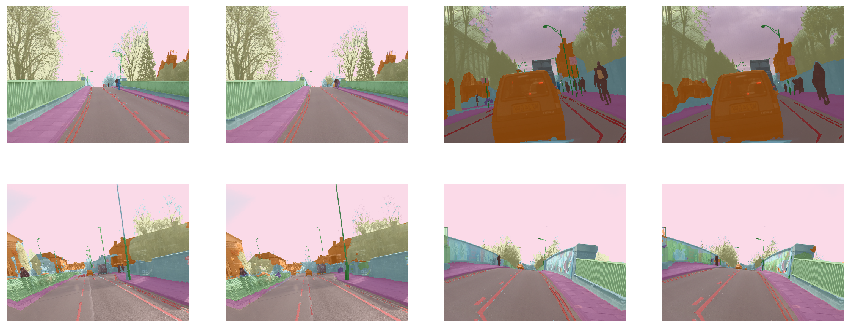

In [ ]:
learn.show_results(max_n=4, vmin=1, vmax=30, figsize=(15,6))